# Programming Lab 3 - Algorithm Exploration

***
##### CS 434 - Data Mining and Machine Learning
##### Oregon State University-Cascades
***

In [107]:
name = "Austin Martin"   # <== fill in
assert name != ""
print(name+'\'s Lab 3 submission')

Austin Martin's Lab 3 submission


***
# Load packages 
***

Any additional packages you need for this lab should be added here.

**DO NOT** import packages anywhere else!

In [108]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats.stats import pearsonr, spearmanr

# add more packages...


C:\Users\Fordr\AppData\Local\Temp\ipykernel_37664\2356453434.py:22: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr
C:\Users\Fordr\AppData\Local\Temp\ipykernel_37664\2356453434.py:22: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr


***
# Background
***

In this lab, you will predict the emotional [valence and arousal](https://en.wikipedia.org/wiki/Emotion_classification#Circumplex_model) values for a dataset of 18k musical songs. 

* **Valence** describes the *attractiveness* (positive valence) or *aversiveness* (negative valence) of stimuli.

* **Arousal** refers to the perceived intensity of an event from very *calming* to highly *exciting* or *agitating*.

![alt text](https://image.slidesharecdn.com/w16-0404-170918170017/95/lyle-ungar-2016-modelling-valence-and-arousal-in-facebook-posts-4-638.jpg?cb=1505759747)

In this lab, we attempt to predict the emotional quality of pieces of music based on Spotify features and the highest ranked Lastfm tag. 

This is a very hard problem. You will have to compare different algorithms and need to tune hyperparameters for each in order to find the "best" approach to predict this data. 

***
# Overview
***

This is a **regression** task in which we predict both <font color="#DC4405">**valence**</font> and <font color="#DC4405">**arousal**</font>. We predict these values separately (separate models for each) but we use the same algorithm (and parameters) for both valence and arousal.

Below, you are given several tasks to complete. You have broad flexibility in how you organize your code, choose which features to use, and find and tune the best algorithm for the task. Make intelligent decisions and justify your choices in the lab report. 

This is a friendly and informal class *competition* in which the goal is to find the best **Pearson's correlation** in the task of predicting valence and arousal. 

You will be primarily graded on your report that describes how and why you made the choices you made. 

***
# Data
***

The following code downloads the data. It is your job to load the various files into several dataframes.

You should use built in pandas functionality to briefly explore each dataframe - `info()`, `describe()` and `display()` are a good place to start.

In [109]:
#  url of the data zip file
url = 'https://github.com/Soundbendor/cs434/raw/master/lab3-deezer.zip'
zip_file = 'lab3-deezer.zip'

# fetch zip file if not already fetched
# !get $url

# unzip file if not already unzipped
# !unzip $zip_file

## Deezer metadata 

This is data about each song including our target valence and arousal values.

Row index ("primary key" across our data files):
* `MSD_track_id` stands for *million song dataset track id* ([more info](http://millionsongdataset.com/))

Metadata (drop before learning):
* `dzr_sng_id` : Deezer song id
* `MSD_sng_id` : MSD song id
* `artist_name` : artist name
* `track_name` : track name

Targets (y values for our two ML models):
* `valence` : valence value of the song
* `arousal` : arousal value of the song

Valence and arousal values for music are difficult to collect via expensive and time-consuiming human subject experiments.  

To create a large dataset, these valence and arousal values were synthetically estimated by the music streaming company [Deezer](https://www.deezer.com/us/) based off of tags from [last.fm](last.fm). There are 18,644 songs in the dataset. Their method is explained in their [academic paper](http://ismir2018.ircam.fr/doc/pdfs/99_Paper.pdf).

In [110]:
# Deezer metadata
# your code to load, display, describe and explore this dataset
df_meta = pd.read_csv('deezer_metadata.csv')
display(df_meta)
df_meta.describe()

,MSD_track_id,dzr_sng_id,MSD_sng_id,artist_name,track_name,valence,arousal
0,TRJIEJX12903CF2202,213754,SORORTY12A67ADD67E,Dark Tranquillity,Insanity's Crescendo,-0.682725,0.316758
1,TRLBHVY128F4242C31,216752,SOVJXGK12A8AE4760C,Anorexia Nervosa,Stabat mater dolorosa,-1.400403,1.538229
2,TRQJZHB128F92FA42D,239138,SOACXLC12AB018218D,Jimmy Witherspoon,Ain't Nobody's Business,-1.935250,-0.655810
3,TRCXLKK128F42366BF,254391,SOUTMGD12A8AE47448,Uniting Nations,Out Of Touch,0.815393,0.662457
4,TRPMWQM128F932C0C8,266313,SOTITAA12A6D4F8DA4,The Walkmen,Brandy alexander,1.257460,1.086515
...,...,...,...,...,...,...,...
18639,TREQLLG128F935A6B5,111894158,SORPIXF12AB01868DD,Arch Enemy,Fields Of Desolation,-1.558674,1.883928
18640,TRAMFAS12903CD7030,112680888,SOCIKSJ12AB018BEAB,Deepest Blue,Is It A Sin,-1.220301,0.644020
18641,TRWSEAE128F93359C4,113204038,SOUPRMS12AB0182A08,The Zombies,I'll Call You Mine,1.178325,1.183311
18642,TRQSIQV128F93085B3,117581660,SOIIDJM12AB017AFEB,Pink Floyd,Comfortably Numb,-0.793515,-0.202252


,dzr_sng_id,valence,arousal
count,1.864400e+04,18644.000000,18644.000000
mean,1.989387e+07,-0.067258,0.195720
std,3.059631e+07,1.057872,0.960662
min,2.137540e+05,-2.148097,-2.333604
25%,1.266104e+06,-1.040199,-0.594407
50%,3.825631e+06,0.032224,0.040198
75%,1.650174e+07,0.815393,0.846830
max,1.242205e+08,1.546714,2.755091


## Spotify features

This data was collected by Corvallis student Shaurya Gaur.  He queried the [Spotify API](https://developer.spotify.com/documentation/web-api/) for the 18,644 songs in the Deezer dataset.



There are 15 features describing the audio of the song.
* `sp_acousticness`
* `sp_danceability`
* `sp_duration_ms`
* `sp_energy`
* `sp_instrumentalness`
* `sp_key`
* `sp_liveness`
* `sp_loudness`
* `sp_mode`
* `sp_speechiness`
* `sp_tempo`
* `sp_time_sig`
* `sp_valence`
* `sp_popularity`
* `sp_explicit`

In [111]:
# Spotify features

# your code to load, display, describe and explore this dataset
df_spot = pd.read_csv('deezer_spotify.csv')
display(df_spot)
df_spot.describe()

,MSD_track_id,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit
0,TRGVJCD128F42623E3,0.131000,0.460,278267.0,0.772,0.041700,0.0,0.0527,-9.233,1.0,0.0445,138.002,4.0,0.532,53.0,False
1,TRNXMAY128F931FAC6,0.394000,0.520,299613.0,0.253,0.000131,0.0,0.1090,-12.407,1.0,0.0344,139.555,3.0,0.219,60.0,False
2,TRYMZQJ128F426A0E7,0.056200,0.909,219840.0,0.740,0.000000,1.0,0.0593,-2.361,1.0,0.2600,97.855,4.0,0.802,54.0,True
3,TRZHHIL128F4264EE0,0.905000,0.701,223613.0,0.202,0.000157,1.0,0.1070,-12.480,1.0,0.0609,85.389,4.0,0.477,53.0,False
4,TRJEBIT128F933A400,0.818000,0.499,298237.0,0.201,0.000001,11.0,0.1430,-12.145,1.0,0.0276,72.139,4.0,0.234,48.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,TREQLLG128F935A6B5,0.000090,0.174,209507.0,0.988,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,True
18640,TRAMFAS12903CD7030,0.000019,0.693,513520.0,0.731,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,False
18641,TRWSEAE128F93359C4,0.133000,0.533,156093.0,0.833,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,False
18642,TRQSIQV128F93085B3,0.150000,0.472,382297.0,0.366,0.308000,11.0,0.0837,-12.595,0.0,0.0286,127.167,4.0,0.171,75.0,False


,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity
count,17755.000000,17755.000000,1.775500e+04,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000
mean,0.261754,0.524219,2.513367e+05,0.622168,0.084401,5.250577,0.187768,-8.454741,0.682343,0.060474,122.019848,3.901774,0.460872,34.162489
std,0.305074,0.159012,8.113700e+04,0.246183,0.208872,3.562207,0.155736,3.975502,0.465578,0.063179,29.232154,0.368029,0.248092,16.678007
min,0.000001,0.000000,3.558700e+04,0.000020,0.000000,0.000000,0.013600,-46.284000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010100,0.416000,2.046600e+05,0.437000,0.000001,2.000000,0.095850,-10.631000,0.000000,0.031400,99.093000,4.000000,0.256000,22.000000
50%,0.111000,0.527000,2.390000e+05,0.651000,0.000189,5.000000,0.125000,-7.641000,1.000000,0.038700,120.116000,4.000000,0.436000,33.000000
75%,0.469000,0.635000,2.820735e+05,0.835000,0.017700,9.000000,0.234000,-5.527000,1.000000,0.059600,140.085000,4.000000,0.655000,46.000000
max,0.995000,0.978000,1.449973e+06,0.999000,0.983000,11.000000,1.000000,3.744000,1.000000,0.954000,217.520000,5.000000,0.984000,84.000000


## Last.fm features

**IMPORTANT** : the lastfm data should only be used directly in our Warmup experiment and should not be used to train your final models. This will be explained as we go.

Deezer used `last.fm tags` to synthetically generate the valence and arousal of their dataset. 

#### All tags
This is dataset of the 5000 most common last.fm tags.  It is a sparse binary matrix which indicates if each song (row) has the respective last.fm tag (column).

In [112]:
# Last FM tag

# your code to load, display, describe and explore this dataset
df_alltags = pd.read_csv('deezer_lastfm_all_tags.csv')
display(df_alltags)
df_alltags.describe()

,-favorites-,00s,1,10s,131,1950s,1960s,1970s,1979,1980s,...,work,world,world fusion,worship,wow,xmas,xynod,yeah,yes,MSD_track_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TRJIEJX12903CF2202
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TRLBHVY128F4242C31
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TRQJZHB128F92FA42D
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TRCXLKK128F42366BF
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TRPMWQM128F932C0C8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TREQLLG128F935A6B5
18639,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TRAMFAS12903CD7030
18640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,TRWSEAE128F93359C4
18641,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,TRQSIQV128F93085B3


,-favorites-,00s,1,10s,131,1950s,1960s,1970s,1979,1980s,...,wonderful,work,world,world fusion,worship,wow,xmas,xynod,yeah,yes
count,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,...,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000
mean,0.009816,0.307890,0.014644,0.008904,0.008582,0.001180,0.012927,0.017165,0.004881,0.025854,...,0.013195,0.018720,0.017594,0.001395,0.004613,0.015287,0.003004,0.007939,0.018935,0.013678
std,0.098591,0.461633,0.120125,0.093943,0.092245,0.034333,0.112963,0.129888,0.069697,0.158705,...,0.114113,0.135539,0.131473,0.037320,0.067764,0.122696,0.054726,0.088747,0.136298,0.116154
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Best tag

This data represents the most common tag associated with with each song on [last.fm](last.fm) if found, or *none* otherwise. 



Row index ("primary key" across data files):
* `MSD_track_id`

Features:
* `lastfm_tag` : string name of tag, or *none*.
* `lastfm_tag_rank` : rank of tag in MSD
  * 0 = none, 1 = most common, 2 = second most common, etc.


The `lastfm_tag` or the `lastfm_tag_rank` can be useful when visualizing your data (e.g., point color).

In [113]:
# Last FM best tag

# your code to load, display, describe and explore this dataset
df_tag = pd.read_csv('deezer_lastfm_best_tag.csv')
display(df_tag)
df_tag.describe()

,MSD_track_id,lastfm_tag,lastfm_tag_rank
0,TRZFLBZ128F92FF270,none,0
1,TRWBOSU128F4281471,none,0
2,TRFFYPU128F149A19D,none,0
3,TRWRAGX128E0784C84,none,0
4,TRAJPQC128F92E6018,none,0
...,...,...,...
18639,TRYCFVF128F9302E9E,the goodbye song,498810
18640,TRNNXFC128F931466A,the word barren,500920
18641,TRAHDJA128E07967E7,the word sod,501681
18642,TRSQPPH128F92E5A5F,tori amosesque,506032


,lastfm_tag_rank
count,18644.000000
mean,3247.188801
std,27040.435300
min,0.000000
25%,4.000000
50%,25.000000
75%,118.000000
max,520008.000000


## Graphing functions

These are provided functions you should use to scatterplot data. Use these functions as they are, do not make any changes. 

> Read the docstrings and skim the code so you know how to use them

In [114]:
def plot_val_vs_aro(valence, arousal, colors='b', plt_size=14, dot_size=20):
    """
    Plot a scatterplot of Valance vs Arousal with labels for each corresponding emotion.

    Args:
        valence (list): list of valance values
        arousal (list): list of arousal values
        colors (str, optional): matplotlib.pyplot color code. Defaults to 'b' for blue tones.
        plt_size (int, optional): plot figure size. Defaults to 14.
        dot_size (int, optional): data point size. Defaults to 20.
    """
    title = 'Valence vs. Arousal'
    x_label = 'Valence'
    y_label = 'Arousal'

    plt.figure(figsize=(plt_size,plt_size))
    plt.scatter(valence, arousal, s=dot_size, c=colors, alpha=.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.xlim(-1.25,1.25)
    plt.ylim(-1.25,1.25)   

    # draw the unit circle
    fig = plt.gcf()
    ax = fig.gca()
    circle1 = plt.Circle((0, 0), 1.0, color='0.25', fill=False)
    ax.add_artist(circle1)

    # print emotion labels
    plt.text(0.98, 0.35, 'Happy', fontsize=plt_size)
    plt.text(0.5, 0.9, 'Excited', fontsize=plt_size)
    plt.text(-1.16, 0.35, 'Afraid', fontsize=plt_size)
    plt.text(-0.7, 0.9, 'Angry', fontsize=plt_size)
    plt.text(-1.13, -0.25, 'Sad', fontsize=plt_size)
    plt.text(-0.9, -0.9, 'Depressed', fontsize=plt_size)
    plt.text(0.98, -0.25, 'Content', fontsize=plt_size)
    plt.text(0.7, -0.9, 'Calm', fontsize=plt_size)


    plt.show()

The above function will plot Valence (`x`-axis) vs Arousal (`y`-axis). 
Example usage:
```python
# Plotting valance vs arousal
plot_val_vs_aro(df_meta['valence'], df_meta['arousal'])
```

In [115]:
def plot_true_vs_pred(true, pred, x_label, y_label, title, colors='b', plt_size=14, dot_size=20) :
    """
    Plot true vs predicted with a regression line of best fit. Can be used for valance OR arousal.

    Args:
        true (list): True values
        pred (list): predicted valaues
        x_label (str): label for true values.
        y_label (str): label for predicted values.
        title (str): title of chart
        colors (str, optional): matplotlib.pyplot color code. Defaults to 'b' for blue tones.
        plt_size (int, optional): plot figure size. Defaults to 14.
        dot_size (int, optional): data point size. Defaults to 20.
    """
    plt.figure(figsize=(plt_size,plt_size))
    plt.scatter(true, pred, s=dot_size, c=colors, alpha=.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    # draw the regression line
    m, b = np.polyfit(true, pred, 1)
    plt.plot(true, m*true + b, color='red', linewidth=2)    

    plt.show()


The above function will plot True values (`x`-axis) vs Predicted values (`y`-axis) for either Valence or Arousal. Provide appropriate axis labels and a chart title as arguments.

Example usage:
```python
plot_true_vs_pred(y_valance_actual, y_valance_predicted, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence')
```
**OR**
```python
plot_true_vs_pred(y_arousal_actual, y_arousal_predicted, 'True Arousal', 'Predicted Arousal', 'True Arousal vs. Predicted Arousal')
```

***
# Pre-work Tasks
***

This section is basic data processing similar to previous labs.

## A: Data preprocessing

#### A.1 Normalize valence and arousal

The valence and arousal values in `df_meta` have already been standardized. However, we want to normalize these values in the range $(-1, 1)$ for graphing. 

In [116]:
# Normalize valence and arousal to (-1,1)
df_meta['valence'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(df_meta['valence']).reshape(-1,1))
df_meta['arousal'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(np.array(df_meta['arousal']).reshape(-1,1))

Confirm your min-max standardization with `describe()`.

In [117]:
# Verify that data is in the appropriate range
df_meta.describe()

,dzr_sng_id,valence,arousal
count,1.864400e+04,18644.000000,18644.000000
mean,1.989387e+07,0.126357,-0.005905
std,3.059631e+07,0.572625,0.377567
min,2.137540e+05,-1.000000,-1.000000
25%,1.266104e+06,-0.400295,-0.316447
50%,3.825631e+06,0.180207,-0.067029
75%,1.650174e+07,0.604136,0.250000
max,1.242205e+08,1.000000,1.000000


#### A.2 Merge dataframes
* [Set 1] : `df_meta`, `df_alltags` and save as `df_lastfm`
* [Set 2] : `df_meta`, `df_tag`, and `df_spot` and save as `df_feats`

In [118]:
# Set 1

df_lastfm = pd.merge(df_meta, df_alltags)

In [119]:
# Set 2

df_feats = pd.merge(df_meta, df_tag)
df_feats = pd.merge(df_feats, df_spot)

#### A.3 Drop all columns you do not want


Drop any columns you don't want that you can justify removing. Think critically about what features are not useful. Useless and redundant features introduce noise and make it harder for a model to converge. Help your model by giving it only the features it needs, nothing more. Thoughtful feature selection will improve your accuracy down the line.


Use *info()* to view a list of column names for each dataframe. Consider which columns are useful and which should be dropped. Some ideas:

* `lastfm_tag` and `lastfm_tag_rank` represent the same feature. Are they both useful? Probably not. Drop one.

* Do track IDs help predict valance/arousal? Probably not. 

* What about the name of the track?

* And so on...



Make sure to drop unwanted columns from both dataframes `df_lastfm` and `df_feats`

In [120]:

# drop features
df_lastfm = df_lastfm.drop(['MSD_track_id', 'dzr_sng_id', 'MSD_sng_id', 'track_name', 'artist_name'], axis=1)
df_feats = df_feats.drop(['MSD_track_id', 'dzr_sng_id', 'MSD_sng_id', 'track_name', 'artist_name', 'lastfm_tag'], axis=1)

#### A.4 Impute the mean for any missing values

Make sure to impute missing values on both dataframes.

In [121]:
# impute NaNs in each column using mean of that column using SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_lastfm = pd.DataFrame(imp.fit_transform(df_lastfm), columns=df_lastfm.columns)
df_feats = pd.DataFrame(imp.fit_transform(df_feats), columns=df_feats.columns)
df_spot = df_spot.drop(['MSD_track_id'], axis=1)
df_spot = pd.DataFrame(imp.fit_transform(df_spot), columns=df_spot.columns)

In [122]:
display(df_feats)

,valence,arousal,lastfm_tag_rank,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit
0,-0.206795,0.041667,189.0,0.001620,0.315,412000.0,0.7950,0.196000,6.0,0.0776,-9.645,0.0,0.0574,138.293,3.0,0.413,18.0,0.0
1,-0.595273,0.521739,172.0,0.000010,0.171,440320.0,0.7980,0.029500,11.0,0.0759,-5.548,0.0,0.0622,110.058,4.0,0.130,19.0,0.0
2,-0.884786,-0.340580,34.0,0.924000,0.579,360640.0,0.0972,0.001050,10.0,0.0766,-13.925,1.0,0.0477,78.526,4.0,0.354,9.0,0.0
3,0.604136,0.177536,9.0,0.008590,0.710,171747.0,0.9630,0.013300,11.0,0.2180,-4.787,0.0,0.0277,129.965,4.0,0.968,51.0,0.0
4,0.843427,0.344203,21.0,0.082700,0.491,148400.0,0.7110,0.000064,10.0,0.2460,-6.463,1.0,0.0330,119.001,4.0,0.545,22.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,-0.680945,0.657609,189.0,0.000090,0.174,209507.0,0.9880,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,1.0
18640,-0.497784,0.170290,2.0,0.000019,0.693,513520.0,0.7310,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,0.0
18641,0.800591,0.382246,56.0,0.133000,0.533,156093.0,0.8330,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,0.0
18642,-0.266765,-0.162319,19.0,0.150000,0.472,382297.0,0.3660,0.308000,11.0,0.0837,-12.595,0.0,0.0286,127.167,4.0,0.171,75.0,0.0


In [123]:
display(df_meta)

,MSD_track_id,dzr_sng_id,MSD_sng_id,artist_name,track_name,valence,arousal
0,TRJIEJX12903CF2202,213754,SORORTY12A67ADD67E,Dark Tranquillity,Insanity's Crescendo,-0.206795,0.041667
1,TRLBHVY128F4242C31,216752,SOVJXGK12A8AE4760C,Anorexia Nervosa,Stabat mater dolorosa,-0.595273,0.521739
2,TRQJZHB128F92FA42D,239138,SOACXLC12AB018218D,Jimmy Witherspoon,Ain't Nobody's Business,-0.884786,-0.340580
3,TRCXLKK128F42366BF,254391,SOUTMGD12A8AE47448,Uniting Nations,Out Of Touch,0.604136,0.177536
4,TRPMWQM128F932C0C8,266313,SOTITAA12A6D4F8DA4,The Walkmen,Brandy alexander,0.843427,0.344203
...,...,...,...,...,...,...,...
18639,TREQLLG128F935A6B5,111894158,SORPIXF12AB01868DD,Arch Enemy,Fields Of Desolation,-0.680945,0.657609
18640,TRAMFAS12903CD7030,112680888,SOCIKSJ12AB018BEAB,Deepest Blue,Is It A Sin,-0.497784,0.170290
18641,TRWSEAE128F93359C4,113204038,SOUPRMS12AB0182A08,The Zombies,I'll Call You Mine,0.800591,0.382246
18642,TRQSIQV128F93085B3,117581660,SOIIDJM12AB017AFEB,Pink Floyd,Comfortably Numb,-0.266765,-0.162319


In [124]:
# clean us individual df's
df_tag = df_tag.drop(['MSD_track_id', 'lastfm_tag'], axis=1)
df_meta = df_meta.drop(['MSD_track_id', 'dzr_sng_id', 'MSD_sng_id', 'track_name', 'artist_name'], axis=1)

#encode categorical data
df_spot['sp_explicit'] = df_spot['sp_explicit'].astype(int)
df_feats['sp_explicit'] = df_feats['sp_explicit'].astype(int)




In [125]:

display(df_feats)
display(df_spot)
display(df_tag)
display(df_meta)

,valence,arousal,lastfm_tag_rank,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit
0,-0.206795,0.041667,189.0,0.001620,0.315,412000.0,0.7950,0.196000,6.0,0.0776,-9.645,0.0,0.0574,138.293,3.0,0.413,18.0,0
1,-0.595273,0.521739,172.0,0.000010,0.171,440320.0,0.7980,0.029500,11.0,0.0759,-5.548,0.0,0.0622,110.058,4.0,0.130,19.0,0
2,-0.884786,-0.340580,34.0,0.924000,0.579,360640.0,0.0972,0.001050,10.0,0.0766,-13.925,1.0,0.0477,78.526,4.0,0.354,9.0,0
3,0.604136,0.177536,9.0,0.008590,0.710,171747.0,0.9630,0.013300,11.0,0.2180,-4.787,0.0,0.0277,129.965,4.0,0.968,51.0,0
4,0.843427,0.344203,21.0,0.082700,0.491,148400.0,0.7110,0.000064,10.0,0.2460,-6.463,1.0,0.0330,119.001,4.0,0.545,22.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,-0.680945,0.657609,189.0,0.000090,0.174,209507.0,0.9880,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,1
18640,-0.497784,0.170290,2.0,0.000019,0.693,513520.0,0.7310,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,0
18641,0.800591,0.382246,56.0,0.133000,0.533,156093.0,0.8330,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,0
18642,-0.266765,-0.162319,19.0,0.150000,0.472,382297.0,0.3660,0.308000,11.0,0.0837,-12.595,0.0,0.0286,127.167,4.0,0.171,75.0,0


,sp_acousticness,sp_danceability,sp_duration_ms,sp_energy,sp_instrumentalness,sp_key,sp_liveness,sp_loudness,sp_mode,sp_speechiness,sp_tempo,sp_time_sig,sp_valence,sp_popularity,sp_explicit
0,0.131000,0.460,278267.0,0.772,0.041700,0.0,0.0527,-9.233,1.0,0.0445,138.002,4.0,0.532,53.0,0
1,0.394000,0.520,299613.0,0.253,0.000131,0.0,0.1090,-12.407,1.0,0.0344,139.555,3.0,0.219,60.0,0
2,0.056200,0.909,219840.0,0.740,0.000000,1.0,0.0593,-2.361,1.0,0.2600,97.855,4.0,0.802,54.0,1
3,0.905000,0.701,223613.0,0.202,0.000157,1.0,0.1070,-12.480,1.0,0.0609,85.389,4.0,0.477,53.0,0
4,0.818000,0.499,298237.0,0.201,0.000001,11.0,0.1430,-12.145,1.0,0.0276,72.139,4.0,0.234,48.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,0.000090,0.174,209507.0,0.988,0.898000,0.0,0.7200,-3.420,0.0,0.1070,126.399,4.0,0.103,27.0,1
18640,0.000019,0.693,513520.0,0.731,0.020700,11.0,0.0737,-6.666,1.0,0.0483,130.033,4.0,0.602,22.0,0
18641,0.133000,0.533,156093.0,0.833,0.000000,0.0,0.2280,-7.706,1.0,0.0334,128.399,4.0,0.581,23.0,0
18642,0.150000,0.472,382297.0,0.366,0.308000,11.0,0.0837,-12.595,0.0,0.0286,127.167,4.0,0.171,75.0,0


,lastfm_tag_rank
0,0
1,0
2,0
3,0
4,0
...,...
18639,498810
18640,500920
18641,501681
18642,506032


,valence,arousal
0,-0.206795,0.041667
1,-0.595273,0.521739
2,-0.884786,-0.340580
3,0.604136,0.177536
4,0.843427,0.344203
...,...,...
18639,-0.680945,0.657609
18640,-0.497784,0.170290
18641,0.800591,0.382246
18642,-0.266765,-0.162319


##### Self-Check
If these do not pass, check your work above. 

In [126]:
assert df_lastfm.isna().sum().sum() == 0
assert df_feats.isna().sum().sum() == 0

##### Visualize processed data
Use our graphing function from earlier to view the processed data.

Think about what exactly this visualization is representing in our data.

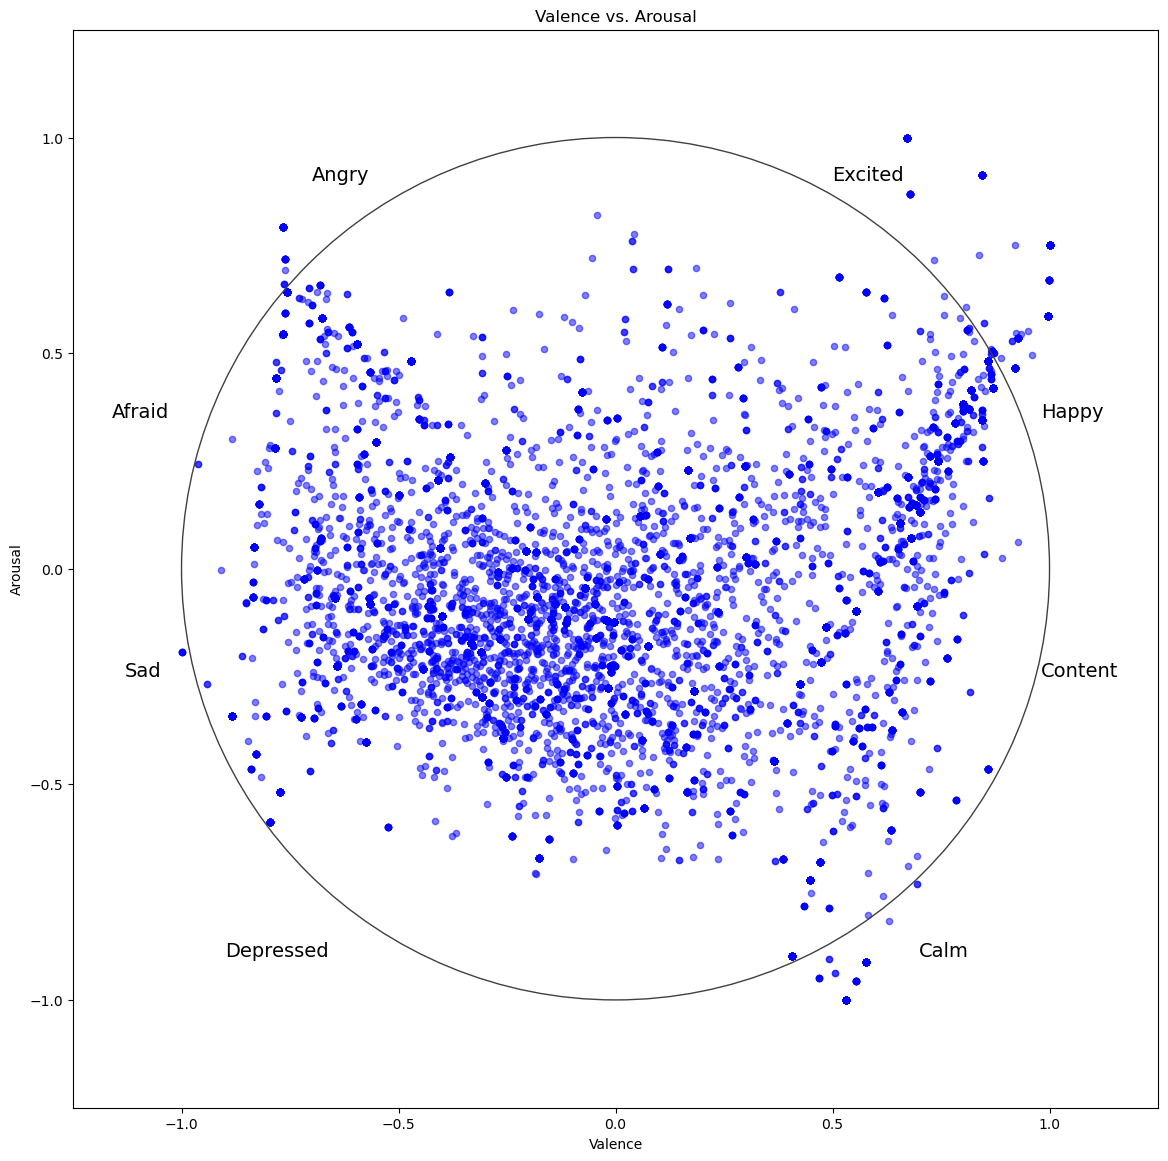

In [127]:
# view our valence-arousal space for our examples
plot_val_vs_aro(df_feats['valence'], df_feats['arousal'])

In [128]:
X = df_feats.drop(['valence', 'arousal'], axis=1)
y_valence = df_feats['valence']
y_arousal = df_feats['arousal']

In [129]:
def perform_pca(df, n_components=20):
    # Extract features from df_feats
    features = df.values

    # Standardize the features
    scaler = StandardScaler()
    features_std = scaler.fit_transform(features)

    # Run PCA with specified number of components
    pca = PCA(n_components=n_components, random_state=1)
    pca.fit_transform(features_std)

    # Graph 'Principal components' vs 'Explained variance ratio'
    plt.plot(range(1, n_components+1), pca.explained_variance_ratio_)
    plt.xlabel('Principal components')
    plt.ylabel('Explained variance ratio')
    plt.show()

    # Choose the number of components that each individually explain >0.01 of the variance
    pca_n_components = sum(pca.explained_variance_ratio_ > 0.01)
    print('Number of components explaining >0.01 of the variance: {}'.format(pca_n_components))
    
    return pca_n_components


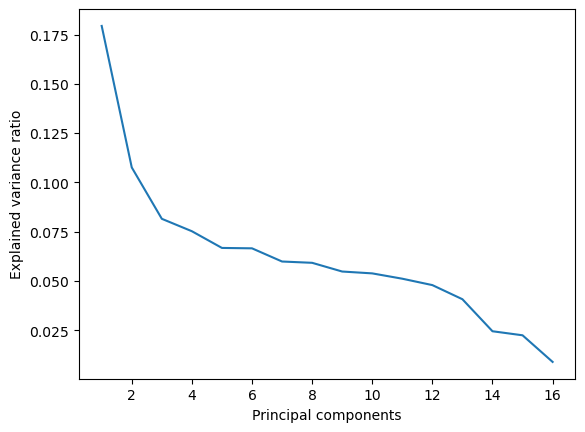

Number of components explaining >0.01 of the variance: 15


In [131]:
pca_n_components = perform_pca(X, n_components=16)

In [133]:
from sklearn.cluster import KMeans

def elbow_method(feats):
# Elbow method for df_acoustic
    dist_acoustic = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=1)
        kmeans.fit(feats)
        dist_acoustic.append(kmeans.inertia_)
    plt.plot(range(1, 11), dist_acoustic)
    plt.xlabel('Number of clusters')
    plt.ylabel('distortion')
    plt.title('Elbow Method - df_acoustic')
    plt.show()

In [135]:
from sklearn.preprocessing import QuantileTransformer

# Transform the features using QuantileTransformer
qt = QuantileTransformer(random_state=1)
spot = qt.fit_transform(df_spot.values)



In [137]:
display(spot)

array([[0.4984985 , 0.32332332, 0.74794551, ..., 0.63063063, 0.86436436,
        0.        ],
       [0.72522523, 0.45495495, 0.82680243, ..., 0.19119119, 0.92692693,
        0.        ],
       [0.38828937, 0.99621978, 0.3374593 , ..., 0.88738739, 0.87487487,
        1.        ],
       ...,
       [0.5005005 , 0.53403403, 0.05104899, ..., 0.68768769, 0.25775776,
        0.        ],
       [0.51851852, 0.35035035, 0.94974941, ..., 0.12712713, 0.99299299,
        0.        ],
       [0.30142741, 0.34284284, 0.95014349, ..., 0.87241125, 0.99049049,
        0.        ]])

In [139]:
# run k means on the transformed features
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(spot)
labels = kmeans.labels_
spot['cluster'] = labels


c:\Users\Fordr\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


AttributeError: 'NoneType' object has no attribute 'split'

In [86]:
#split data into train, test and validate sets for neural network
X = df_feats.drop(['valence', 'arousal'], axis=1)
y_valence = df_feats['valence']
y_arousal = df_feats['arousal']

X_train, X_test, y_train, y_test = train_test_split(X, y_valence, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# create neural network
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

# make a decaying learning rate
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

optimizer = keras.optimizers.Adam(lr=0.01)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# train neural network
history = model.fit(X_train, y_train, epochs=20, batch_size=12, validation_data=(X_val, y_val), callbacks=[callback]) 

preds = model.predict(X_test)
preds = preds.reshape(-1)
# get pearson correlation
corr, _ = pearsonr(preds, y_test)
print('Pearsons correlation: %.3f' % corr)


Epoch 1/20


c:\Users\Fordr\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


KeyboardInterrupt: 

#### A.5 Function to split `X` and `y`

For your different experiments, you will have make various `X` and `y` splits from above sets of data. `X` will be the features for training/testing and `y` will be the target values of either `'valence'` **or** `'arousal'`.

Here you should make yourself a helper function to split `X` and `y` depending on a given dataframe and desired predictor (valence or arousal).

Write your function such that it can split generically based on the arguments passed. Return a new dataframe - do not change either of the original dataframes (`df_lastfm`, `df_feats`) in this function.

Make sure `valence` and `arousal` do not appear in `X`.

**PROTIP** : `'MSD_track_id'`, `'Deezer song id'`, `'MSD_sng_id'`, `'artist_name'`, `'track_name'`,  `'lastfm_tag'`, `'valence'`, and `'arousal'` should not be used in training models. If you didn't drop them above, make sure not to include them in `X`. 

You may use the best `'lastfm_tag_rank'` as a feature (if useful)

In [ ]:
# split a data frame based on the predictor (valence or arousal)
def X_y_split(df, predictor):
    
    X = df.drop(['valence', 'arousal'], axis=1).values
    y = df[predictor].values
    return X, y

##### Self Check

In [ ]:
# test split function
X, y = X_y_split(df_feats, 'valence')
assert y.shape == (18644,)

## B. Build Training and Testing Function



> Using $k$-fold cross-validation, this function finds a prediction for each song in set of `X` and `y` and determines the average Pearson's correlation score across folds.

Write a function `train_and_test_CV` that 

1. build `k` folds with `KFold` partitions on `X` and `y`
2. enumerate over the folds
 * train `model` on the train fold
 * predict `model` on the test fold
 * find predictions for the fold, append to list of predictions
 * find the Pearson's correlation score on the fold, save in list
3. return list of `y_preds` and the average Pearson correlation across the `k` folds
 * This should be a tuple containing `(y_preds, avgerage_correlation)` where `y_preds` is a list of predictions and `average_correlation` is a float

```python
# usage
y_preds, pearson_corr = train_and_test_CV(model, X, y, k=4)
```

This is a general function we reuse in a variety of experiments, for both valence and arousal prediction (depending on the target `y` passed).

In [ ]:
# cross validation train and test
def train_and_test_CV(model, X, y, k=4):
  y_preds = []
  avg_r = []
  # k-fold CV
  kf = KFold(n_splits=k).split(X, y)

  for k, (train, test) in enumerate(kf):
    model.fit(X[train], y[train])
    pred = model.predict(X[test])
    pearson_r, _ = pearsonr(pred, y[test])
    avg_r.append(pearson_r)
    y_preds.extend(pred)
    print('Fold: %2d, Pearsonr: %.3f' % (k+1, pearson_r))
  
  print('\nAvg Pearson R: %.3f\n' % np.mean(avg_r))
  
  return y_preds, np.mean(avg_r)

## C. Warmup Experiment

The valence and arousal values we are trying to predict in this lab were synthetically generated using the last.fm tags data.

As a warmup experiment, lets build models to predict valence and arousal using these last.fm tags. Becuase these values are correlated, it should be easy to get a very accurate model.

There is no code to write here - this section is here to help you wrap your mind around this dataset and to make sure all of your `X_y_split` and `train_and_test_CV` functions are working. 

#### C.1 Predict valence and arousal from last.fm tags

Use a `RandomForestRegressor` to predict both valence and arousal from   `df_lastfm` [Set 1]. 
* `random_state=1`
* `n_estimators=10`
* `k=5` folds of CV


This will take a few minutes to run.

In [ ]:
# Build X and y sets out of the df_lastfm dataset to predict valence
X_valence_lastfm, y_valence_lastfm_true = X_y_split(df_lastfm, 'valence')

# Build a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

# Fit the Regressor 
y_valence_lastfm_pred, lastfm_valence_corr = train_and_test_CV(regressor, X_valence_lastfm, y_valence_lastfm_true, k=5)

# Print the average correlation
print('Valence r %.3f' % lastfm_valence_corr)

Fold:  1, Pearsonr: 0.915
Fold:  2, Pearsonr: 0.926
Fold:  3, Pearsonr: 0.920
Fold:  4, Pearsonr: 0.938
Fold:  5, Pearsonr: 0.927

Avg Pearson R: 0.925

Valence r 0.925


In [ ]:
# Build X and y sets out of the df_lastfm dataset to predict arousal
X_arousal_lastfm, y_arousal_lastfm_true = X_y_split(df_lastfm, 'arousal')

# Build a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

# Fit the Regressor 
y_arousal_lastfm_pred, lastfm_arousal_corr = train_and_test_CV(regressor, X_arousal_lastfm, y_arousal_lastfm_true, k=5)

# Print the average correlation
print('Arousal r %.3f' % lastfm_arousal_corr)

Fold:  1, Pearsonr: 0.913
Fold:  2, Pearsonr: 0.923
Fold:  3, Pearsonr: 0.911
Fold:  4, Pearsonr: 0.915
Fold:  5, Pearsonr: 0.904

Avg Pearson R: 0.913

Arousal r 0.913


#### C.2 Graph your true vs your predicted for each valence and arousal.

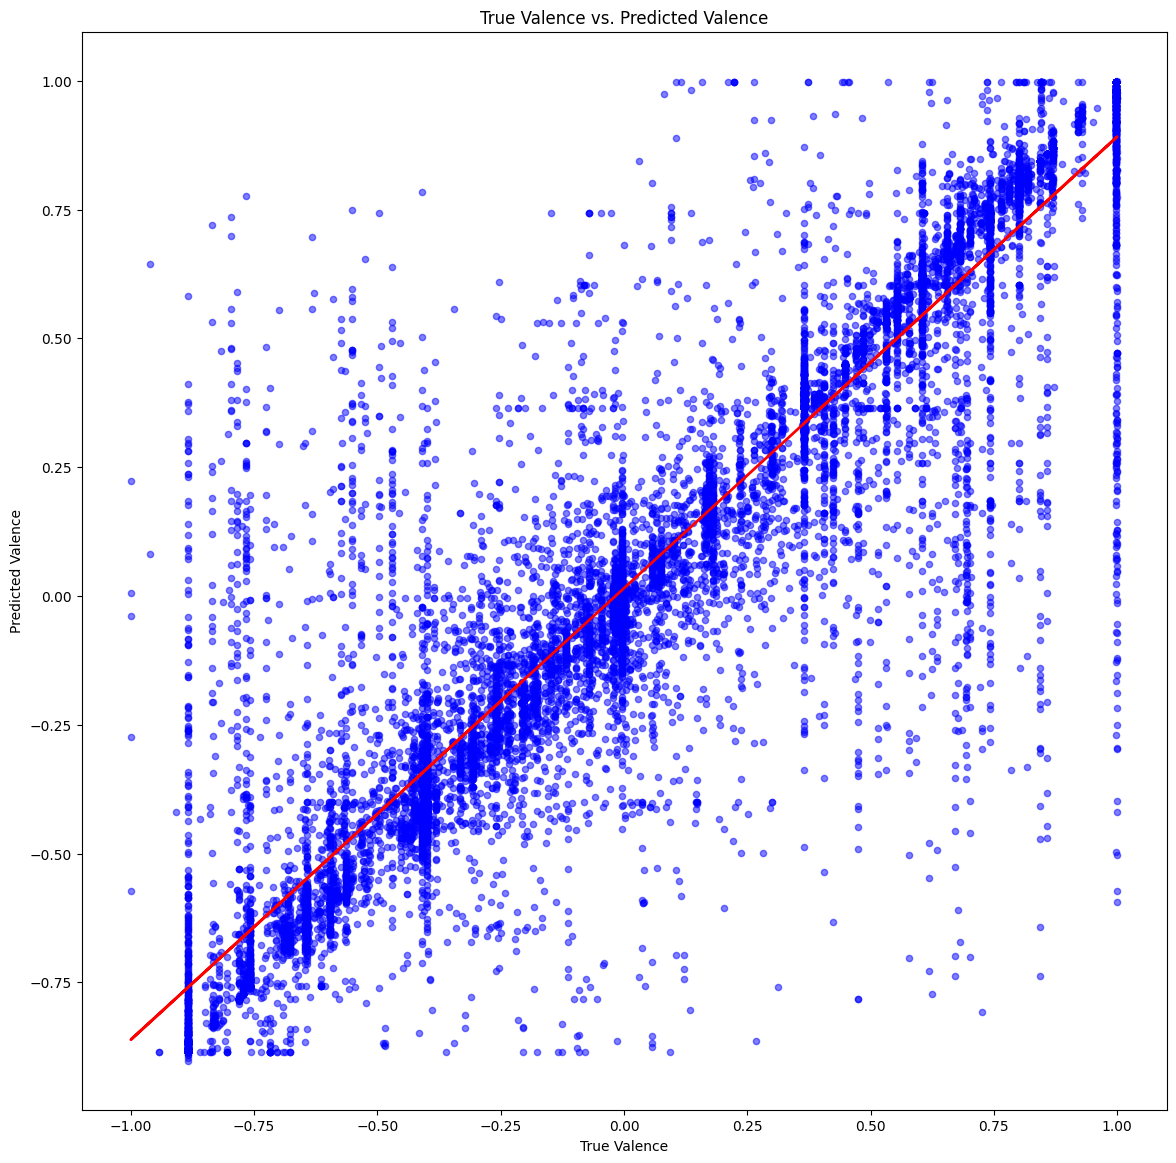

In [ ]:
# plot true valence vs predicted valence
plot_true_vs_pred(np.array(y_valence_lastfm_true), y_valence_lastfm_pred, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence')

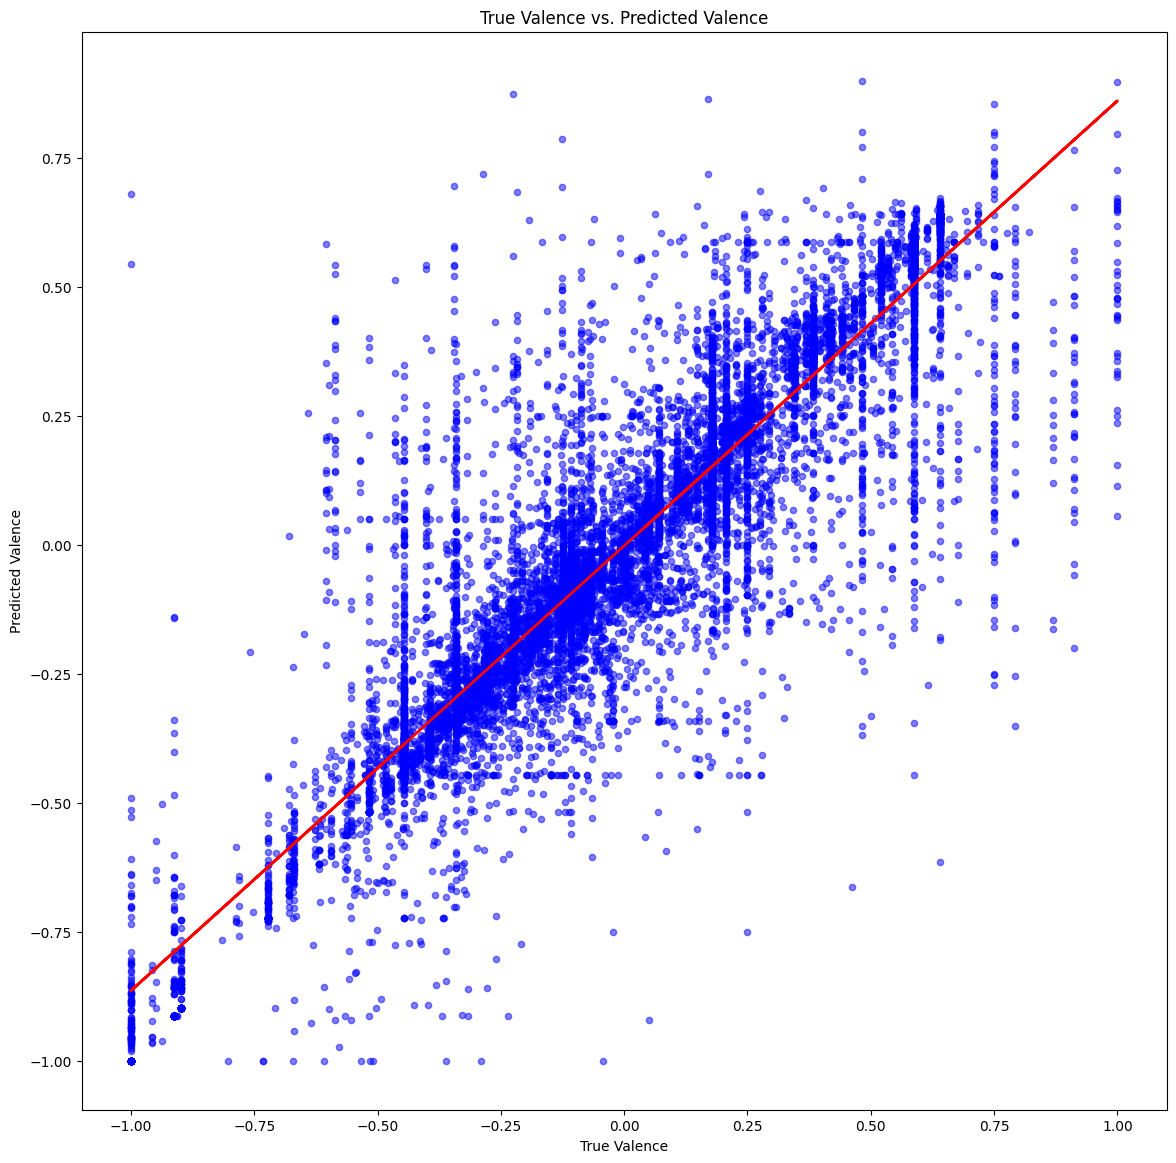

In [ ]:
# plot true arousal vs predicted arousal
plot_true_vs_pred(y_arousal_lastfm_true, y_arousal_lastfm_pred, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence')

##### Self Check
> Since the last.fm tags were used to create the Deezer valence-arousal, we expect a very high correlation ($>0.90$). Check your work if these asserts fail.

In [ ]:
assert(lastfm_valence_corr > 0.9)
assert(lastfm_arousal_corr > 0.9)

We will not use the `df_lastfm` tags [Set 1] for the remainder of this Lab (that would be cheating). Clear the dataframe to make sure you do not use it by accident.

In [ ]:
df_lastfm = pd.DataFrame()
assert(len(df_lastfm) == 0)

***
# Experiments
***

Your turn. You will conduct a series of experiments similar to the warmup above, except using `df_feats` instead of `df_lastfm`. You will explore many models and find the best one for this task.

 **PROTIP** : You will complete your experiments here and test your models.  But, you should write your code as functions so that you can call them (again) later in the report section.  

For all experiments, use Cross-Validation. You may decide which value of $k$ to use ($k>1$). 

Wherever relevant, use `random_state=1`.

## A. Model Selection


* Consider the first 1000 records from `df_feats`. We will use this subset to find a "best model" and parameters (otherwise experimentation will take forever).

* Choose three (or more) regressors from https://scikit-learn.org/stable/supervised_learning.html.

* Use `train_and_test_CV` for cross-validation. Choose a value of $k$ for cross-validation.

* Tune your models. You may use any technique we have learned so far including (but not limited to):
  * dropping features, standardizing features, feature selection, dimensionality reduction (PCA), and/or parameter grid-search (`GridSearchCV`)
  
 
* Compare and determine the best model and parameters that work best for both valence and arousal.

##### **Note**: YOU WILL SCORE POORLY IF YOU DO THE BARE MINIMUM

For full points, you must:
* Document your code clearly
* Use functions to logically decompose the problem
* Create and tune 3+ viable models
* Quantitatively compare all models and justify your choice

In [ ]:
df_feats_1000 = df_feats.sample(n=1000, random_state=1)

In [ ]:
def v_a_splits(df):
    X_v, y_v = X_y_split(df, 'valence')
    X_a, y_a = X_y_split(df, 'arousal')
    
    return X_v, y_v, X_a, y_a

In [ ]:
# Your code to train, tune and test various models
'''
    Gridseach method for tuning this regressor    

    param_test = various params - most important to least - at various times.
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    gsearch1 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=144, max_depth=7, min_samples_split=224, min_samples_leaf=48, min_weight_fraction_leaf=0.0, max_features=7, max_leaf_nodes=56, random_state=1),
    param_grid = param_test, n_jobs=-1, cv=cv)
    gsearch1.fit(X_v, y_v)
    print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
'''
def RandoForest(X, y):
    pipe_forest = Pipeline([('scaler', StandardScaler()),
                            ('forest', RandomForestRegressor(n_estimators=144,
                                                             max_depth=7,
                                                             min_samples_split=224,
                                                             min_samples_leaf=48,
                                                             min_weight_fraction_leaf=0.0,
                                                             max_features=7,
                                                             max_leaf_nodes=56,
                                                             random_state=1,
                                                             n_jobs=-1))])
    y_preds, avg_r = train_and_test_CV(pipe_forest, X, y, k=5)
    return y_preds, avg_r

''' 
    Gridseach method for tuning this regressor    

    param_test = various params - most important to least - at various times.
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    gsearch1 = GridSearchCV(estimator = RidgeCV(alphas=[14, 15, 16], scoring='neg_mean_squared_error', gcv_mode='auto', cv=4),  
    param_grid = param_test, n_jobs=-1, cv=cv)
    gsearch1.fit(X_v, y_v)
    print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
'''
def Ridge_model(X, y):
    pipe_ridge = Pipeline([('scaler', StandardScaler()),
                           ('ridge', RidgeCV(alphas=[14, 15, 16], 
                                             scoring='neg_mean_squared_error', 
                                             gcv_mode='auto', 
                                             cv=4))])
    y_preds, avg_r = train_and_test_CV(pipe_ridge, X, y, k=5)
    return y_preds, avg_r

''' 
    Gridseach method for tuning this regressor    

    param_test = various params - most important to least - at various times.
    cv = KFold(n_splits=2, random_state=1, shuffle=True)
    gsearch1 = GridSearchCV(estimator = KNeighborsRegressor(n_neighbors=416, weights='uniform', metric='manhattan', algorithm='kd_tree', leaf_size=19, n_jobs=-1),  
    param_grid = param_test, n_jobs=-1, cv=cv)
    gsearch1.fit(X_v, y_v)
    print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
'''
def KNN_model(X, y):
    pipe_knn = Pipeline([('scaler', StandardScaler()),
                         ('knn', KNeighborsRegressor(n_neighbors=412,
                                                     weights='uniform',
                                                     metric='manhattan',
                                                     algorithm='kd_tree',
                                                     leaf_size=19,
                                                     n_jobs=-1))])
    y_preds, avg_r = train_and_test_CV(pipe_knn, X, y, k=5)
    return y_preds, avg_r

'''
    Gridseach method for tuning this regressor  

    param_test = various params - most important to least - at various times.
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    gsearch1 = GridSearchCV(estimator = HistGradientBoostingRegressor(loss='squared_error', learning_rate=.01, max_iter=700, max_leaf_nodes=43, max_depth=23, min_samples_leaf=75, warm_start=True, random_state=1), 
    param_grid = param_test, n_jobs=-1, cv=cv)
    gsearch1.fit(X_v, y_v)
    print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_)) # summarize all scores that were evaluated
'''
from sklearn.ensemble import HistGradientBoostingRegressor
def Boost_model(X, y):
    pipe_boost = Pipeline([('scaler', StandardScaler()),
                           ('boost', HistGradientBoostingRegressor(loss='squared_error',
                                                                   learning_rate=.01,
                                                                   max_iter=700,
                                                                   max_leaf_nodes=43,
                                                                   max_depth=23,
                                                                   min_samples_leaf=75,
                                                                   warm_start=True,
                                                                   random_state=1))])
    y_preds, avg_r = train_and_test_CV(pipe_boost, X, y, k=100)
    return y_preds, avg_r

# voting model for our 4 tuned regressors
def Voting_model(X, y):
    # define the estimators
    estimators = [('random_forest', RandomForestRegressor(n_estimators=144,
                                                          max_depth=7,
                                                          min_samples_split=224,
                                                          min_samples_leaf=48,
                                                          min_weight_fraction_leaf=0.0,
                                                          max_features=7,
                                                          max_leaf_nodes=56,
                                                          random_state=1,
                                                          n_jobs=-1)),
                  ('ridge', RidgeCV(alphas=[14, 15, 16], 
                                    scoring='neg_mean_squared_error', 
                                    gcv_mode='auto', 
                                    cv=4)),
                  ('knn', KNeighborsRegressor(n_neighbors=412,
                                                     weights='uniform',
                                                     metric='manhattan',
                                                     algorithm='kd_tree',
                                                     leaf_size=19,
                                                     n_jobs=-1)),
                  ('boost', HistGradientBoostingRegressor(learning_rate=0.075,
                                                               n_estimators=120,
                                                               max_depth=8,
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_features=16,
                                                               subsample=0.8,
                                                               random_state=1))]
    # define the voting ensemble - VotingRegressor
    pipe_voting = Pipeline([('scaler', StandardScaler()),
                            ('voting', VotingRegressor(estimators=estimators, n_jobs=-1, weights=[1,1,1,3]))])
    
    y_preds, avg_r = train_and_test_CV(pipe_voting, X, y, k=5)
    return y_preds, avg_r

# Boost_Model ended up working the best for me
# However it was accidentally trained and optimized on the entire dataset

## B. Full Experiment

Use your best model and parameters from Experiment #1. Train this model on the full dataset `df_feats`.

For each valence and arousal:
* print the Pearson's correlation
* plot true vs predicted

This is a hard, real-world problem. High correlations are hard to achieve. How well can you do?
> If your correlation is < 0.36, you probably have not tried hard enough in part A and likely will not recieve full credit. Strive for a correlation > 0.4.

Fold:  1, Pearsonr: 0.499
Fold:  2, Pearsonr: 0.493
Fold:  3, Pearsonr: 0.502
Fold:  4, Pearsonr: 0.531
Fold:  5, Pearsonr: 0.499
Fold:  6, Pearsonr: 0.564
Fold:  7, Pearsonr: 0.506
Fold:  8, Pearsonr: 0.564
Fold:  9, Pearsonr: 0.571
Fold: 10, Pearsonr: 0.472
Fold: 11, Pearsonr: 0.479
Fold: 12, Pearsonr: 0.349
Fold: 13, Pearsonr: 0.521
Fold: 14, Pearsonr: 0.583
Fold: 15, Pearsonr: 0.492
Fold: 16, Pearsonr: 0.628
Fold: 17, Pearsonr: 0.462
Fold: 18, Pearsonr: 0.482
Fold: 19, Pearsonr: 0.545
Fold: 20, Pearsonr: 0.514
Fold: 21, Pearsonr: 0.556
Fold: 22, Pearsonr: 0.481
Fold: 23, Pearsonr: 0.503
Fold: 24, Pearsonr: 0.491
Fold: 25, Pearsonr: 0.580
Fold: 26, Pearsonr: 0.604
Fold: 27, Pearsonr: 0.339
Fold: 28, Pearsonr: 0.500
Fold: 29, Pearsonr: 0.460
Fold: 30, Pearsonr: 0.557
Fold: 31, Pearsonr: 0.525
Fold: 32, Pearsonr: 0.617
Fold: 33, Pearsonr: 0.491
Fold: 34, Pearsonr: 0.353
Fold: 35, Pearsonr: 0.603
Fold: 36, Pearsonr: 0.485
Fold: 37, Pearsonr: 0.628
Fold: 38, Pearsonr: 0.385
Fold: 39, Pe

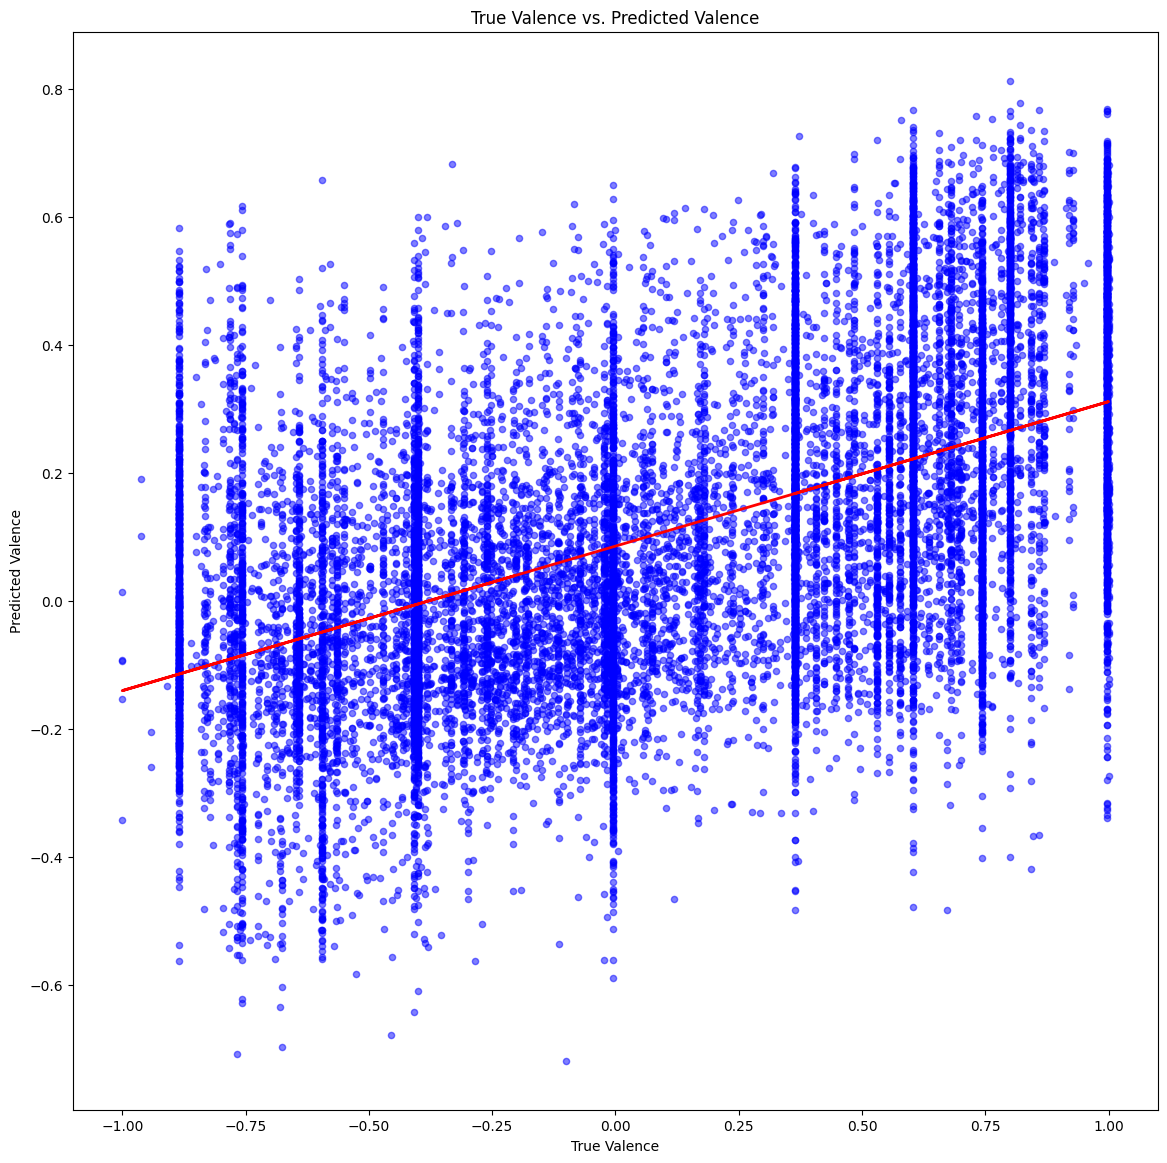

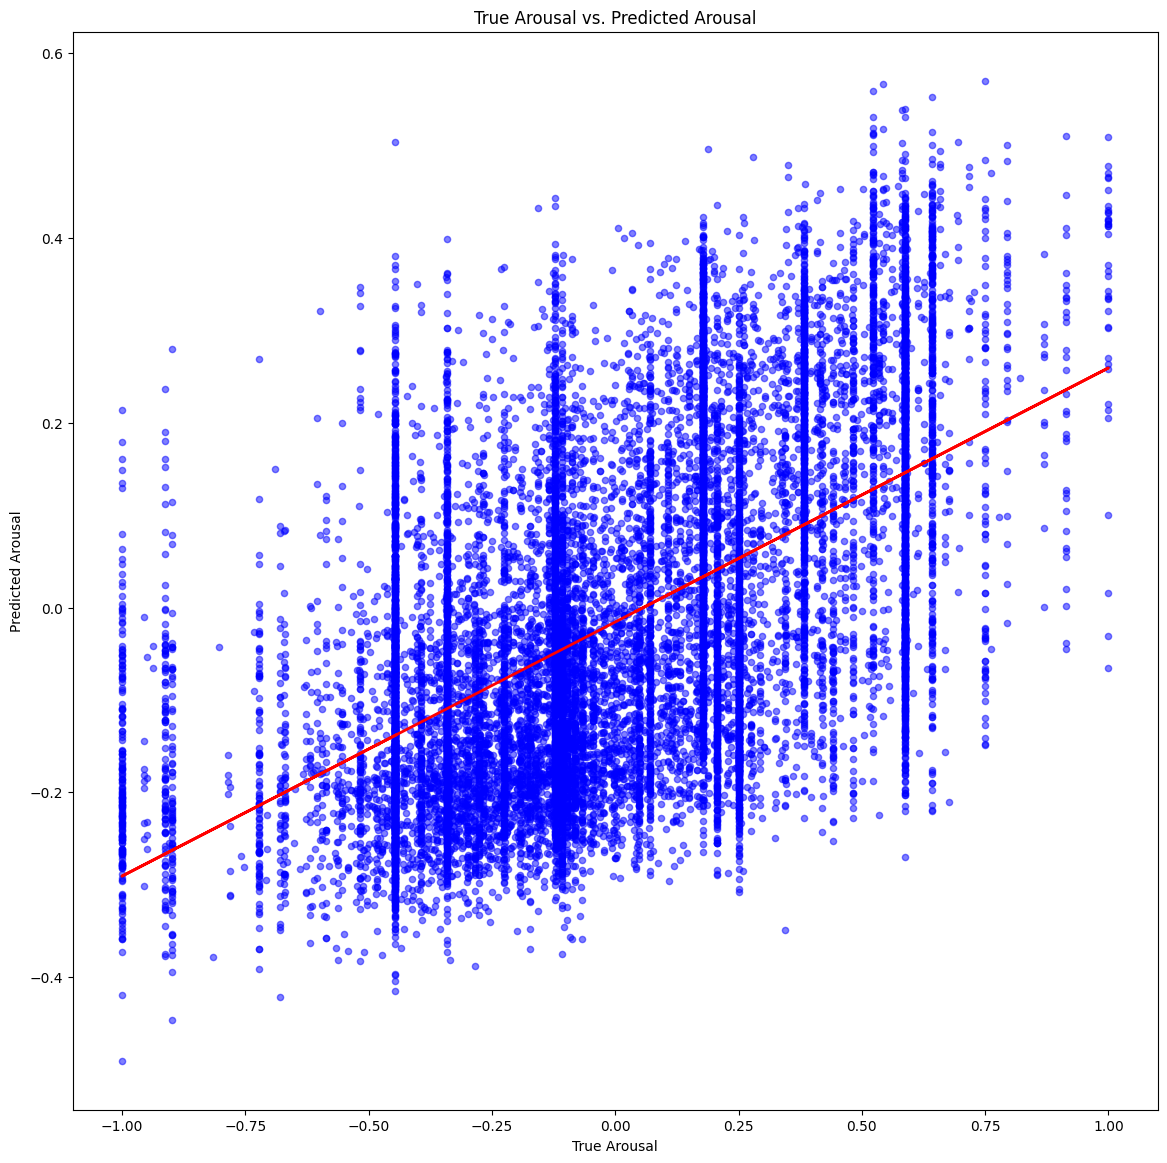

In [ ]:
# Your code to train and test your best model on the full dataset

# Build X and y sets out of the df_feats dataset to predict valence
X_valence, y_valence, X_arousal, y_arousal = v_a_splits(df_feats)

# train and test the model
y_valence_pred, valence_corr = Boost_model(X_valence, y_valence)
y_arousal_pred, arousal_corr = Boost_model(X_arousal, y_arousal)

# Print the average correlation
print('Valence r: %.3f' % valence_corr)
print('Arousal r: %.3f' % arousal_corr)

# plot true valence vs predicted valence
plot_true_vs_pred(y_valence, y_valence_pred, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence')

# plot true arousal vs predicted arousal
plot_true_vs_pred(y_arousal, y_arousal_pred, 'True Arousal', 'Predicted Arousal', 'True Arousal vs. Predicted Arousal')

***
# Lab Report
***

#### Directions

Following your experimentation, complete a mini-lab report. You should include a **paragraph or more** for each of the following sections. 
 1. Problem Statement
 1. Methods
 1. Results
 1. Discussion & Conclusion

 Explain what models you chose, how you tuned them and what your results were. Focus on **why** you did what you did. Justify your choices. Reference course concepts.

> **Intermingle text and code. Call your previously defined functions to demonstrate results and display graphs.**
> You will not recieve full credit if you only use text/markdown cells.

You do not need to document your Pre-work in the Report - just your model tuning.

#### Tips

**You will be graded on your report below** (not on your code above).  

* Write in complete sentences. Take pride in your write-up. 
* Proof-read your work. Lazy reports receive medicore grades.  
* Explain and justify all your experimental design choices.
* In your discussion, convey your understanding of your results (don't just describe your graphs). 
* Label your graph and make them pretty. Use color.
* Use markup to make your report look nicer

***
## Report
***

**Problem Statement**: Our objective was to try to predict the valence and arousal in a piece of music given a set of data with attributes describin the music. Our data came primarily from spotify regarding a set of 18644 songs. We were given some different different attributes of those songs according to spotify. We were also given the valence and arousal of the same set of songs which we included into our overall dataframe (df_feats). After compiling and cleaning our data, our goal was to explore some regressor models and try to train and tune them to find the best model giving us the highest correlation between predictions and results. Then we printed and graphed our results to show that correlation.

**Methods**: We were asked to write a train and test cross validation function which would run a cross validation on any of our regressor models that returns an average Pearson's R value and a set of predictions for valence or arousal. I remember reading that when the order of the samples doesn't carry meaningful information, then shuffling is generally a good idea. So I tried setting my K-Fold like so:

In [ ]:
# cross validation train and test
def train_and_test_CV(model, X, y, k=4):
  y_preds = []
  avg_r = []
  # k-fold CV
  kf = KFold(n_splits=k, shuffle=True, random_state=1).split(X, y)

  for k, (train, test) in enumerate(kf):
    model.fit(X[train], y[train])
    pred = model.predict(X[test])
    pearson_r, _ = pearsonr(pred, y[test])
    avg_r.append(pearson_r)
    y_preds.extend(pred)
    print('Fold: %2d, Pearsonr: %.3f' % (k+1, pearson_r))
  
  print('\nAvg Pearson R: %.3f\n' % np.mean(avg_r))
  
  return y_preds, np.mean(avg_r)

In the KFold initialization I gave the arguments shuffle=True and random_state=1. Doing this ended up given me better Pearson's r values however it absolutely scattered my scatter plot because the 'y_true' values were not randomized in the same way as the 'y_pred' values (given to us from randomized 'X[test]' values). I think their must be a way to utilize the increased correlation that randomization gives us, while still being able to correctly graphs/visualize the correlation afterwards, but I was unsure how to accopmlish that.  

Next I tried to think of the best regressors for this type of data. It seemed to me that it would be hard to correctly classify this data linearly so I started by exploring a non_linear regressor and the regressor given to us in the practice experiment, a Random Forest Regressor. I wanted to see how each regressor I chose would do with default arguments so I first ran this and each of the next regressor with default arguments first to get an idea of which regressor might be better suited to this task. Random forest did alright but I was getting right around that 0.37 mark for my average correlations.

Then I decided to compare it against a linear regressor so I ran a RidgeCV regressor with default arguments. I picked RidgeCV vs Ridge because I thought the extra cross validation might help. Running this with default arguments also gave me right around a 0.37 r value. 

From there I tried a K Nearest Neighbor Regressor, thinking that this might help to inform more accurate predictions, given that the data is not very linear, and also knowing that it is a pretty tunable model. Running with default arguments gave me an r value of about 0.28, a significant drop, but n_neighbors was 10.

Finally, I wanted to try a Booster. We have done an ADAbooster in class already, so I read about the Gradient Boosting Regressor in the link supplied to us. Unlike an ada booster which uses stumps and the mispredictions they cause to make informed decisions on new stumps, the Graident Boosting Regressor is able to use full size trees and their faults to inform the next tree it builds. This seemed more targeted than a random forest and more tunable than the adabooster so I went with it. This model ran with default arguments ended up giving me r values of ~0.41 right off the bat. The only draw back was that it ran pretty slowly. I went back to the documentation and found the HistGradientBoostingRegressor which was recommended for datasets > 10,000 samples. Using this regressor with default setting gave me r values of ~0.425 in fractions of the time. 

My next step was to Tune the models. My approach was to use GridSearchCV to find the best hyperparameters for each regressor. I used the following code block to test various parameter sets:

In [ ]:
# X_v, y_v = X_y_split(df_feats, 'valence')
# param_test = []#various params - most important to least - at various times.
# cv = KFold(n_splits=5, random_state=1, shuffle=True)
# gsearch1 = GridSearchCV(estimator = '''Insert model here( insert best params here)''',
# param_grid = param_test, n_jobs=-1, cv=cv)
# gsearch1.fit(X_v, y_v)
# print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))

I would start with no parameters in the **'(insert best params here)'** section and place high consequence parameters (such as n_estimators/n_neighbors) in the **'param_test='** section. Once I got the best parameter I would move that into the **'(insert best params here)'** section and then repeat with the rest of the parameters for the model, trying to go from most important to least important. Here is an example below:

In [ ]:
X_v, y_v = X_y_split(df_feats, 'valence')
param_test = {'n_neighbors': range(100,401, 100)}
cv = KFold(n_splits=2, random_state=1, shuffle=True)
gsearch1 = GridSearchCV(estimator = KNeighborsRegressor(),  
param_grid = param_test, n_jobs=-1, cv=cv)
gsearch1.fit(X_v, y_v)
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))

Best: 0.020041 using {'n_neighbors': 400}


I would then place n_neighbors=400 in the parameters of the KNeighborsRegressor() and repeat with the other parameters. I would also try to narrow it down a bit further to get a more accurate number for n_neighbors but I did not in this example.

****ALSO:**** I originally thought that I was tuning on a sample df of 1000 songs from df_feats, but it turns out I was tuning to the entire df_feats.

**Results:** After tuning all of the hyper parameters for my models I was able to get r scores of ~0.4 or more for each model. For the HistGradientBoostingRegressor I got r scores of ~0.47. Ithen tried a VotingRegressor with all 4 models but it performed worse than the HistGradientBoostingRegressor alone, making that my model of choice. Because of its VERY good performance, I was able to increase the k-folds to increase my r scores. At k=100 I was able to get my r scores all the way up to 0.523 for valence and 0.571 for arousal. 

Fold:  1, Pearsonr: 0.499
Fold:  2, Pearsonr: 0.493
Fold:  3, Pearsonr: 0.502
Fold:  4, Pearsonr: 0.531
Fold:  5, Pearsonr: 0.499
Fold:  6, Pearsonr: 0.564
Fold:  7, Pearsonr: 0.506
Fold:  8, Pearsonr: 0.564
Fold:  9, Pearsonr: 0.571
Fold: 10, Pearsonr: 0.472
Fold: 11, Pearsonr: 0.479
Fold: 12, Pearsonr: 0.349
Fold: 13, Pearsonr: 0.521
Fold: 14, Pearsonr: 0.583
Fold: 15, Pearsonr: 0.492
Fold: 16, Pearsonr: 0.628
Fold: 17, Pearsonr: 0.462
Fold: 18, Pearsonr: 0.482
Fold: 19, Pearsonr: 0.545
Fold: 20, Pearsonr: 0.514
Fold: 21, Pearsonr: 0.556
Fold: 22, Pearsonr: 0.481
Fold: 23, Pearsonr: 0.503
Fold: 24, Pearsonr: 0.491
Fold: 25, Pearsonr: 0.580
Fold: 26, Pearsonr: 0.604
Fold: 27, Pearsonr: 0.339
Fold: 28, Pearsonr: 0.500
Fold: 29, Pearsonr: 0.460
Fold: 30, Pearsonr: 0.557
Fold: 31, Pearsonr: 0.525
Fold: 32, Pearsonr: 0.617
Fold: 33, Pearsonr: 0.491
Fold: 34, Pearsonr: 0.353
Fold: 35, Pearsonr: 0.603
Fold: 36, Pearsonr: 0.485
Fold: 37, Pearsonr: 0.628
Fold: 38, Pearsonr: 0.385
Fold: 39, Pe

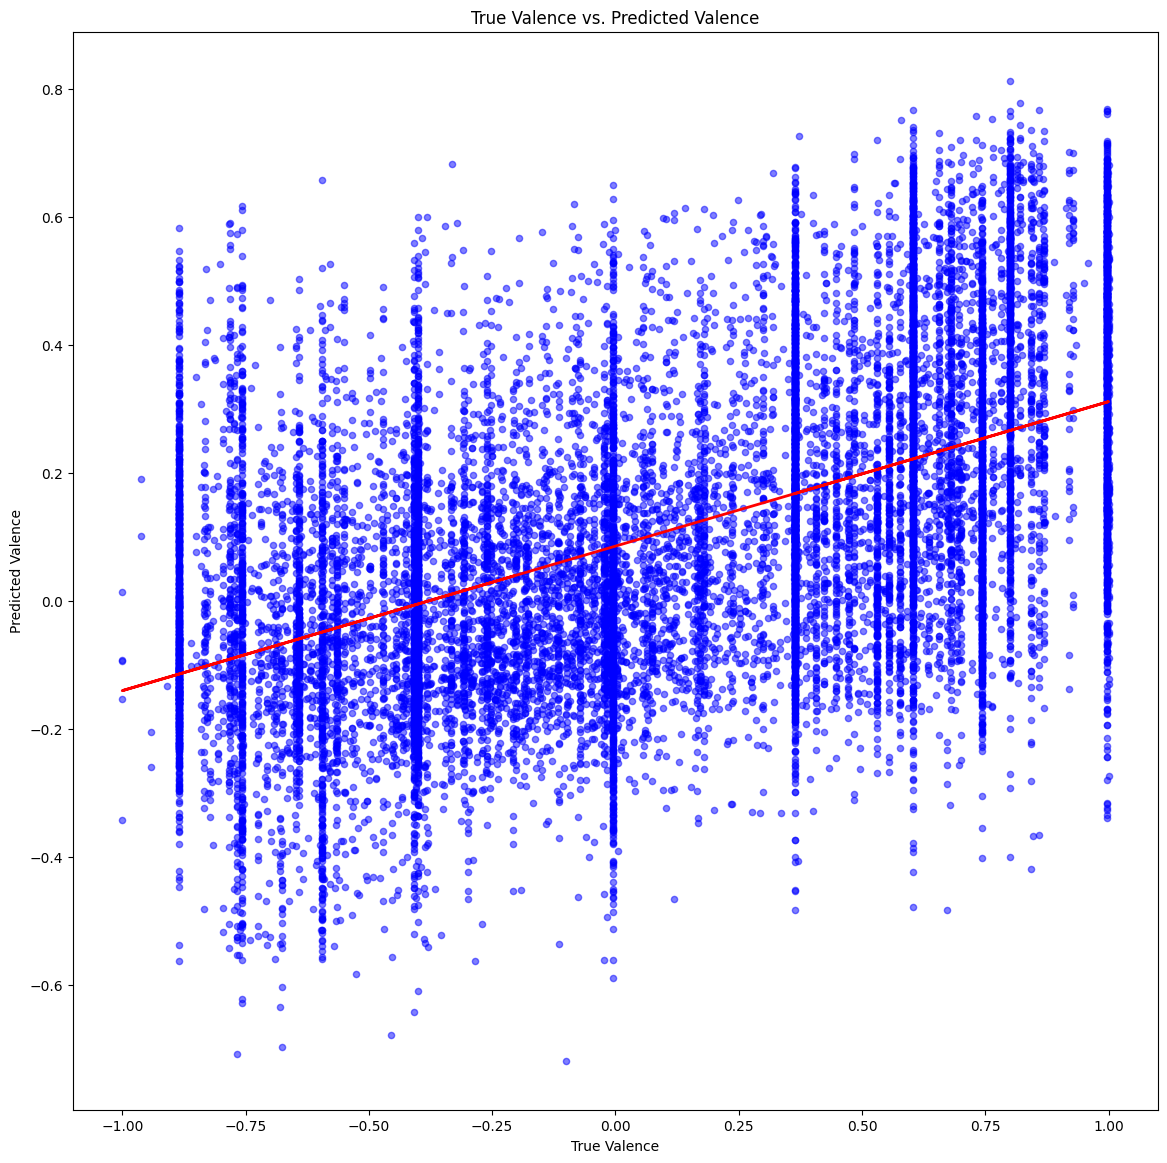

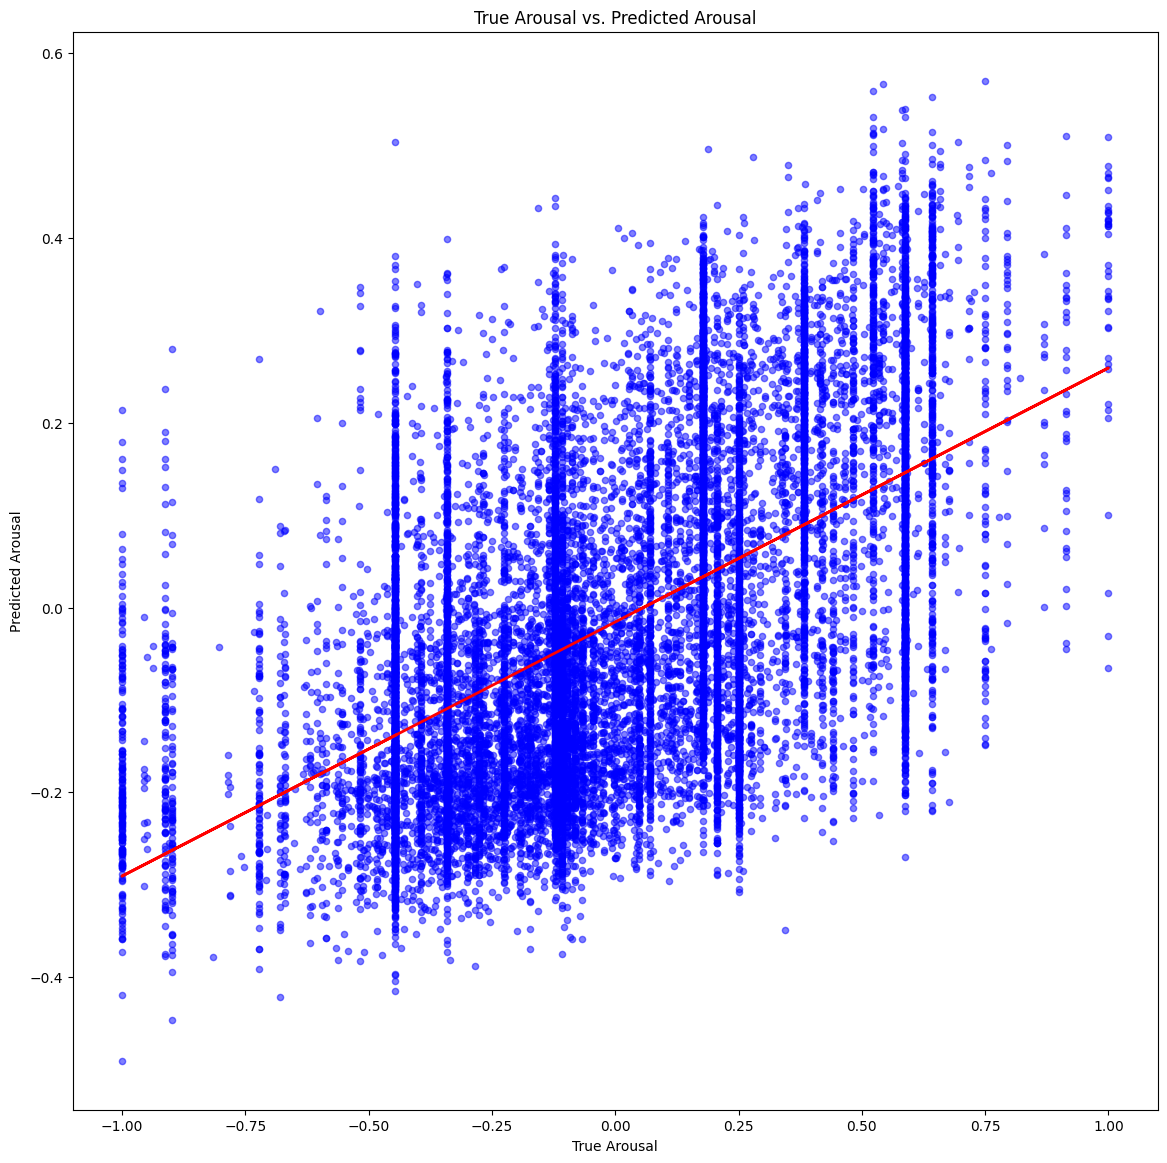

In [ ]:
X_valence, y_valence, X_arousal, y_arousal = v_a_splits(df_feats)

# train and test the model
y_valence_pred, valence_corr = Boost_model(X_valence, y_valence)
y_arousal_pred, arousal_corr = Boost_model(X_arousal, y_arousal)

# Print the average correlation
print('Valence r: %.3f' % valence_corr)
print('Arousal r: %.3f' % arousal_corr)

# plot true valence vs predicted valence
plot_true_vs_pred(y_valence, y_valence_pred, 'True Valence', 'Predicted Valence', 'True Valence vs. Predicted Valence')

# plot true arousal vs predicted arousal
plot_true_vs_pred(y_arousal, y_arousal_pred, 'True Arousal', 'Predicted Arousal', 'True Arousal vs. Predicted Arousal')

**Discussion & Conclusions:** There are a few things that I think contributed to these results. The use of the HistGradientBoostingRegressor allowed for the use of a loss function to learn from the trees that it was creating, the ability to change the learning rate, increasing the ability to decrease error, The ability to define the max depth and leaves, the ability to define minimum samples per leaf, the amount of bins (which allow for increased performance and a fast training stage), and the ability to have a 'warm start' which allows you to reuse the solution of the previous fit call and add more estimators to the ensemble. All of these parameters allow you to really customize your model so that it can better capture the complexity of this data. I again think I could have gotten even better results if I used **shuffle=True** and **random_state=1** in the **KFold()** initialization in **train_and_test_cv()**, but I was unsure how to fix the issue of our predictions getting randomized and not ending up in line with our testing. In fact, I only think that is the issue. It might be something else all together. 